In [2]:


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi


os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# 1. Load and prepare dataset
df = pd.read_csv("Linhac24-25_Sportlogiq.csv")
df = df.sort_values(by=['gameid', 'compiledgametime'])

# ========== 2. Event flags with renamed variables ==========
df['num_passes'] = (df['eventname'] == 'pass').astype(int)
df['num_zone_entries'] = (df['eventname'] == 'controlledentry').astype(int)
df['num_assists'] = (df['eventname'] == 'assist').astype(int)
df['num_blocks'] = (df['eventname'] == 'block').astype(int)
df['num_entries_against'] = (df['eventname'] == 'controlledentryagainst').astype(int)
df['num_dumpouts'] = (df['eventname'] == 'dumpout').astype(int)
df['num_shots'] = df['eventname'].isin(['shot', 'goal']).astype(int)

# ========== 3. Success flags ==========
df['num_successful_passes'] = ((df['eventname'] == 'pass') & (df['outcome'] == 'successful')).astype(int)
df['num_successful_zone_entries'] = ((df['eventname'] == 'controlledentry') & (df['outcome'] == 'successful')).astype(int)
df['num_successful_entries_against'] = ((df['eventname'] == 'controlledentryagainst') & (df['outcome'] == 'successful')).astype(int)

# ========== 4. Carry duration & distance ==========
df['is_carry'] = (df['eventname'] == 'carry').astype(int)
carry_df = df[df['is_carry'] == 1].copy()
carry_df['next_x'] = df['xadjcoord'].shift(-1)
carry_df['next_y'] = df['yadjcoord'].shift(-1)
carry_df['carry_distance'] = np.sqrt((carry_df['next_x'] - carry_df['xadjcoord'])**2 + (carry_df['next_y'] - carry_df['yadjcoord'])**2)
carry_df['carry_duration'] = df['compiledgametime'].shift(-1) - carry_df['compiledgametime']
carry_avg = carry_df.groupby(['teamid', 'gameid'])[['carry_distance', 'carry_duration']].mean().reset_index()
carry_avg.rename(columns={'carry_distance': 'avg_carry_distance', 'carry_duration': 'avg_carry_duration'}, inplace=True)

# ========== 5. Aggregated metrics ==========
agg_cols = [
    'num_passes', 'num_successful_passes', 'num_zone_entries', 'num_successful_zone_entries',
    'num_assists', 'num_blocks', 'num_entries_against', 'num_dumpouts', 'num_shots'
]
agg_dict = {col: 'sum' for col in agg_cols}
agg_dict['xg_allattempts'] = 'mean'
agg_df = df.groupby(['teamid', 'gameid']).agg(agg_dict).reset_index()
agg_df = agg_df.merge(carry_avg, on=['teamid', 'gameid'], how='left')

# ========== 6. Final score + result ==========
last_score = df.sort_values(['gameid', 'compiledgametime']).groupby(['teamid', 'gameid'])['scoredifferential'].last().reset_index()
agg_df = agg_df.drop(columns='scoredifferential', errors='ignore')
agg_df = agg_df.merge(last_score, on=['teamid', 'gameid'], how='left')
agg_df['result'] = agg_df['scoredifferential'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 0.5))

# ========== 7. Derived success rates ==========
agg_df['pass_success_rate'] = agg_df['num_successful_passes'] / agg_df['num_passes'].replace(0, np.nan)
agg_df['entry_success_rate'] = agg_df['num_successful_zone_entries'] / agg_df['num_zone_entries'].replace(0, np.nan)

entry_against_stats = df.groupby(['teamid', 'gameid'])[['num_successful_entries_against', 'num_entries_against']].sum().reset_index()
entry_against_stats['entry_against_success_rate'] = entry_against_stats['num_successful_entries_against'] / entry_against_stats['num_entries_against'].replace(0, np.nan)
agg_df = agg_df.merge(entry_against_stats[['teamid', 'gameid', 'entry_against_success_rate']], on=['teamid', 'gameid'], how='left')

# ========== 8. Feature list for clustering ==========
features_v2 = [
    'num_passes', 'num_zone_entries', 'num_assists', 'num_blocks',
    'num_entries_against', 'num_dumpouts', 'num_shots', 'xg_allattempts',
    'pass_success_rate', 'entry_success_rate', 'entry_against_success_rate',
    'avg_carry_duration', 'avg_carry_distance'
]

scaler = StandardScaler()
X_full = scaler.fit_transform(agg_df[features_v2])

# Fit KMeans
kmeans_base = KMeans(n_clusters=3, random_state=42)
kmeans_base.fit(X_full)

# Save original cluster labels and style mapping
agg_df['cluster'] = kmeans_base.predict(X_full)
style_names = {0: 'Puck Control Play', 1: 'Defensive Counterattack', 2: 'High-Pressure Offense'}
agg_df['style'] = agg_df['cluster'].map(style_names)

#agg_df.to_csv("/Users/liuhuaide/Desktop/clustered_team_styles.csv", index=False)


c:\Users\yanjie\anaconda3\envs\hockey\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [3]:
# ==================================================================
# --- Analysis Preparation: Generate Core Matchup Data ---
# ==================================================================

df_matches = agg_df[['gameid', 'teamid', 'style', 'result']].copy()
df_matches = df_matches.merge(df_matches, on='gameid')
df_matches = df_matches[df_matches['teamid_x'] < df_matches['teamid_y']].copy()

records = []
for _, row in df_matches.iterrows():
    s1, r1 = row['style_x'], row['result_x']
    s2, r2 = row['style_y'], row['result_y']
    if r1 == 1: records.append((s1, s2, 'win')); records.append((s2, s1, 'loss'))
    elif r2 == 1: records.append((s1, s2, 'loss')); records.append((s2, s1, 'win'))
    else: records.append((s1, s2, 'draw')); records.append((s2, s1, 'draw'))
#print("\n--- Analysis Preparation: Core Matchup Data Generation Complete ---")



In [4]:
# ==================================================================
# --- Welch’s independent samples t-tests  ---
# ==================================================================
from scipy.stats import ttest_ind

#feature_cols = features_v2 + ['pass_success_rate', 'entry_success_rate', 'entry_against_success_rate']
feature_cols = features_v2
style_list = agg_df['style'].unique()

results = []

for feat in feature_cols:
    for i in range(len(style_list)):
        for j in range(i + 1, len(style_list)):
            s1 = style_list[i]
            s2 = style_list[j]
            vals1 = agg_df[agg_df['style'] == s1][feat].dropna()
            vals2 = agg_df[agg_df['style'] == s2][feat].dropna()
            t_stat, p_val = ttest_ind(vals1, vals2, equal_var=False)  # Welch t-test 更稳健
            results.append({
                'feature': feat,
                'style1': s1,
                'style2': s2,
                't_stat': t_stat,
                'p_value': p_val
            })

t_test_df = pd.DataFrame(results)
t_test_df['significant'] = t_test_df['p_value'] < 0.05



#print(t_test_df[t_test_df['significant']].sort_values(by='p_value').head(10))
# 显示所有列，不省略
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)  # 设置足够大以防表被截断

# 按 p 值排序查看完整表格
t_test_df_sorted = t_test_df.sort_values(by='p_value')
#t_test_df_sorted.to_csv("t_test_results_sorted.csv", index=False)

In [5]:
# ==================================================================
# Part 2: Bootstrap Validation
# ==================================================================
print("\n--- Part 2: Bootstrap Validation ---")
matchup_df = df_matches[
    ((df_matches['style_x'] == 'Defensive Counterattack') & (df_matches['style_y'] == 'Puck Control Play')) |
    ((df_matches['style_x'] == 'Puck Control Play') & (df_matches['style_y'] == 'Defensive Counterattack'))
].copy()

total_games = len(matchup_df)
wins = 0
for _, row in matchup_df.iterrows():
    if (row['style_x'] == 'Defensive Counterattack' and row['result_x'] == 1) or \
       (row['style_y'] == 'Defensive Counterattack' and row['result_y'] == 1):
        wins += 1
    elif row['result_x'] == 0.5:
        wins += 0.5
original_win_rate = wins / total_games if total_games > 0 else 0

n_iterations = 1000
bootstrap_win_rates = []

for i in range(n_iterations):
    sample = matchup_df.sample(n=len(matchup_df), replace=True)
    wins_sample = 0
    total_games_sample = len(sample)
    if total_games_sample == 0: continue
    for _, row in sample.iterrows():
        if (row['style_x'] == 'Defensive Counterattack' and row['result_x'] == 1) or \
           (row['style_y'] == 'Defensive Counterattack' and row['result_y'] == 1):
            wins_sample += 1
        elif row['result_x'] == 0.5:
            wins_sample += 0.5
    bootstrap_win_rates.append(wins_sample / total_games_sample)

if bootstrap_win_rates:
    lower_bound = np.percentile(bootstrap_win_rates, 2.5)
    upper_bound = np.percentile(bootstrap_win_rates, 97.5)
    print(f"Bootstrap for 'Defensive Counterattack' vs 'Puck Control Play'")
    print(f"Original win rate: {original_win_rate:.2%}, 95% confidence interval: [{lower_bound:.2%}, {upper_bound:.2%}]")



--- Part 2: Bootstrap Validation ---
Bootstrap for 'Defensive Counterattack' vs 'Puck Control Play'
Original win rate: 82.14%, 95% confidence interval: [69.64%, 92.86%]


Robustness Verification of the Win Rate for “Counter-Attack vs Possession”

To verify the statistical robustness of the key finding in this study—that the “Counter-Attack” style achieves a high win rate of 82.14% against the “Possession” style—and to exclude the possibility that this result was caused by small-sample bias, we applied a bootstrap resampling method. We performed 1000 bootstrap samples with replacement from all match samples of this specific matchup, calculating the win rate for each sample to construct the empirical distribution of the win rate.

The analysis results show that the 95% confidence interval for the “Counter-Attack” style win rate is [69.64%, 92.86%].

The lower bound of this interval (69.64%) is significantly higher than the 50% chance level, indicating that even after accounting for sampling variability, the “Counter-Attack” style maintains a decisive tactical advantage. Therefore, it can be concluded that the high win rate observed in this study is not a statistical fluke but a stable manifestation of a significant tactical counter relationship between the two styles. This result provides strong data support for our subsequent discussions on style dynamics and tactical applications.

In [10]:
# ==================================================================
# Part 3: Chi-Square Test
# ==================================================================
from scipy.stats import chi2_contingency
print("\n--- Part 3: Chi-Square Test ---")
results_df = pd.DataFrame(records, columns=['style_team', 'style_opp', 'outcome'])
crosstab = pd.crosstab(index=[results_df['style_team'], results_df['style_opp']], columns=results_df['outcome'])
if all(col in crosstab.columns for col in ['draw', 'loss', 'win']):
    crosstab = crosstab[['draw', 'loss', 'win']]
print("Contingency table of Style vs. Style match results:")
print(crosstab)
chi2, p, dof, expected = chi2_contingency(crosstab)
print(f"Chi-square test p-value: {p:.4f}")
if p < 0.05: print("Conclusion: There is a significant association between style combinations and match outcomes.")
else: print("Conclusion: There is no significant association between style combinations and match outcomes.")


--- Part 3: Chi-Square Test ---
Contingency table of Style vs. Style match results:
outcome                                          draw  loss  win
style_team              style_opp                               
Defensive Counterattack Defensive Counterattack     0    10   10
                        High-Pressure Offense      20    33   42
                        Puck Control Play           6     2   20
High-Pressure Offense   Defensive Counterattack    20    42   33
                        High-Pressure Offense       2     6    6
                        Puck Control Play           2     0    5
Puck Control Play       Defensive Counterattack     6    20    2
                        High-Pressure Offense       2     5    0
                        Puck Control Play           4     7    7
Chi-square test p-value: 0.0001
Conclusion: There is a significant association between style combinations and match outcomes.


Testing the Association Between Match Styles and Match Outcomes

To statistically examine the core premise of this study—that the combination of playing styles of the two competing teams is significantly associated with the final match result (win, draw, loss)—we constructed a contingency table of style matchups versus match outcomes (as shown in Table X) and performed Pearson’s Chi-squared test. The null hypothesis of this test is that the combination of playing styles and match outcomes are independent, meaning that specific style combinations do not systematically affect the probabilities of winning, losing, or drawing.

The test result shows a chi-square p-value of 0.0001.

This p-value is far below the conventional significance level (α = 0.05), giving us sufficient reason to reject the null hypothesis. The result indicates a highly significant statistical association between playing style combinations and match outcomes. This provides fundamental empirical evidence for the subsequent in-depth exploration of which style combinations confer tactical advantages or disadvantages, and it confirms the validity of tactical analyses based on playing styles.


--- Section 4: Check sample sizes and compute weighted win rates ---
Sample sizes of matchup combinations (symmetric matrix, diagonal adjusted):
style_y                  Defensive Counterattack  High-Pressure Offense  \
style_x                                                                   
Defensive Counterattack                       10                     95   
High-Pressure Offense                         95                      7   
Puck Control Play                             28                      7   

style_y                  Puck Control Play  
style_x                                     
Defensive Counterattack                 28  
High-Pressure Offense                    7  
Puck Control Play                        9  

Weighted Win Rate Matrix:
style_opp               Defensive Counterattack High-Pressure Offense  \
style_team                                                              
Defensive Counterattack                     0.5               0.53253   
High-Pr

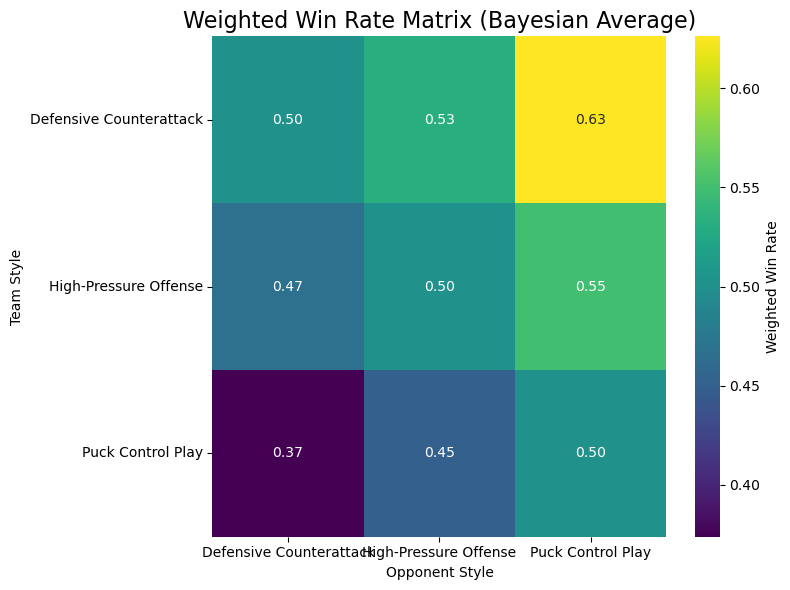

In [11]:
# ==================================================================
# Section 4: Check sample sizes and compute weighted win rates
# ==================================================================
print("\n--- Section 4: Check sample sizes and compute weighted win rates ---")
matchup_counts = df_matches.groupby(['style_x', 'style_y']).size().unstack(fill_value=0)
matchup_counts_sym = matchup_counts.add(matchup_counts.T, fill_value=0)
np.fill_diagonal(matchup_counts_sym.values, np.diag(matchup_counts_sym) // 2)
print("Sample sizes of matchup combinations :")
print(matchup_counts_sym)

winrate_numeric = results_df.assign(win=results_df['outcome'].map({'win': 1, 'draw': 0.5, 'loss': 0}))
winrate_table = winrate_numeric.groupby(['style_team', 'style_opp'])['win'].mean().unstack()
prior_mean = 0.5
credibility_constant = matchup_counts_sym.values[np.triu_indices(len(matchup_counts_sym), k=1)].mean()
weighted_win_rate_table = pd.DataFrame(index=winrate_table.index, columns=winrate_table.columns)

for team_style in winrate_table.index:
    for opp_style in winrate_table.columns:
        original_rate = winrate_table.loc[team_style, opp_style]
        num_games = matchup_counts_sym.get(opp_style, {}).get(team_style, 0)
        if pd.notna(original_rate):
            weighted_rate = (credibility_constant * prior_mean + num_games * original_rate) / (credibility_constant + num_games)
            weighted_win_rate_table.loc[team_style, opp_style] = weighted_rate
        else:
            weighted_win_rate_table.loc[team_style, opp_style] = np.nan
print("\nWeighted Win Rate Matrix:")
print(weighted_win_rate_table.round(2))

print("\n--- Plotting Weighted Win Rate Heatmap ---")
plt.figure(figsize=(8, 6))
sns.heatmap(
    weighted_win_rate_table.astype(float), 
    annot=True, 
    fmt=".2f", 
    cmap="viridis", 
    cbar_kws={"label": "Weighted Win Rate"}
)
plt.title("Weighted Win Rate Matrix (Bayesian Average)", fontsize=16)
plt.xlabel("Opponent Style")
plt.ylabel("Team Style")
plt.tight_layout()
plt.show()


When analyzing the win rate relationships among various playing styles, we observed significant differences in the number of matches between different style matchups (as shown in Table Y), with some matchups having very small sample sizes—for example, only 7 games between “High Pressure Attack” and “Possession.” To correct for potential biases in win rate estimates caused by small sample sizes and to generate a more robust style matchup matrix, we applied Bayesian averaging to smooth the raw win rates. This method “pulls” the win rates of low-sample matchups toward the prior mean of 50%, while having less impact on matchups with larger sample sizes.

The resulting weighted win rate matrix (as shown in Table Z) and the corresponding heatmap (Figure X) reveal the adjusted style dynamics. The results indicate that the “Counter-Attack” style shows an advantage against the other two styles, with a win rate of 53.3% against “High Pressure Attack” and as high as 62.6% against “Possession.” Notably, for the matchup with the smallest sample size—“High Pressure Attack” versus “Possession”—the weighted win rate (55.0%) was effectively adjusted toward the 50% baseline. This adjustment mitigates the risk of drawing extreme conclusions from only 7 matches, thereby enhancing the reliability of the results.

This weighted matrix provides a fairer and statistically more robust perspective to understand the mutual counter relationships among different ice hockey playing styles.



In [12]:
# ==================================================================
# Part 5: Cross-Validation (70/30 split, validating model stability)
# ==================================================================
print("\n--- Part 5: Cross-Validation ---")
def calculate_weighted_win_rate_matrix(df):
    """
    Takes a DataFrame as input, dynamically calculates the credibility_constant,
    and returns the weighted win rate matrix.
    """

    df_matches_cv = df[['gameid', 'teamid', 'style', 'result']].copy()
    df_matches_cv = df_matches_cv.merge(df_matches_cv, on='gameid', suffixes=('_x', '_y'))
    df_matches_cv = df_matches_cv[df_matches_cv['teamid_x'] < df_matches_cv['teamid_y']].copy()
    
    if df_matches_cv.empty:
        return pd.DataFrame()

    records_cv = []
    for _, row in df_matches_cv.iterrows():
        s1, r1, s2, r2 = row['style_x'], row['result_x'], row['style_y'], row['result_y']
        if r1 == 1: records_cv.append((s1, s2, 'win')); records_cv.append((s2, s1, 'loss'))
        elif r2 == 1: records_cv.append((s1, s2, 'loss')); records_cv.append((s2, s1, 'win'))
        else: records_cv.append((s1, s2, 'draw')); records_cv.append((s2, s1, 'draw'))
    
    if not records_cv:
        return pd.DataFrame()

    results_df_cv = pd.DataFrame(records_cv, columns=['style_team', 'style_opp', 'outcome'])
    winrate_numeric_cv = results_df_cv.assign(win=results_df_cv['outcome'].map({'win': 1, 'draw': 0.5, 'loss': 0}))
    winrate_table_cv = winrate_numeric_cv.groupby(['style_team', 'style_opp'])['win'].mean().unstack()
    
    matchup_counts_cv = pd.crosstab(df_matches_cv['style_x'], df_matches_cv['style_y'])
    matchup_counts_sym_cv = matchup_counts_cv.add(matchup_counts_cv.T, fill_value=0)
    np.fill_diagonal(matchup_counts_sym_cv.values, np.diag(matchup_counts_sym_cv) // 2)

    prior_mean = 0.5
    matchup_values = matchup_counts_sym_cv.values[np.triu_indices(len(matchup_counts_sym_cv), k=1)]
    if matchup_values.size > 0:
        credibility_constant = matchup_values.mean()
    else:
        credibility_constant = 20 # fallback value
    
    weighted_win_rate_table_cv = (credibility_constant * prior_mean + matchup_counts_sym_cv * winrate_table_cv) / (credibility_constant + matchup_counts_sym_cv)
    
    return weighted_win_rate_table_cv

game_ids = agg_df['gameid'].unique()
train_game_ids, test_game_ids = train_test_split(game_ids, test_size=0.3, random_state=42)
train_df = agg_df[agg_df['gameid'].isin(train_game_ids)]
test_df = agg_df[agg_df['gameid'].isin(test_game_ids)]

win_rate_train_weighted = calculate_weighted_win_rate_matrix(train_df)
win_rate_test_weighted = calculate_weighted_win_rate_matrix(test_df)

print("\n--- Weighted Win Rate Matrix on Training Set (70% of data) ---")
print(win_rate_train_weighted.to_string(float_format="{:.2f}".format))
print("\n--- Weighted Win Rate Matrix on Test Set (30% of data) ---")
print(win_rate_test_weighted.to_string(float_format="{:.2f}".format))


--- Part 5: Cross-Validation ---

--- Weighted Win Rate Matrix on Training Set (70% of data) ---
style_y                  Defensive Counterattack  High-Pressure Offense  Puck Control Play
style_x                                                                                   
Defensive Counterattack                     0.50                   0.52               0.62
High-Pressure Offense                       0.48                   0.50               0.53
Puck Control Play                           0.38                   0.47               0.50

--- Weighted Win Rate Matrix on Test Set (30% of data) ---
style_y                  Defensive Counterattack  High-Pressure Offense  Puck Control Play
style_x                                                                                   
Defensive Counterattack                     0.50                   0.56               0.64
High-Pressure Offense                       0.44                   0.50               0.58
Puck Control Play      

Cross-Validation: Evaluating Model Stability and Generalization Ability

To assess the stability and generalization ability of the style matchup model identified in this study, we employed a cross-validation approach. The entire match dataset was randomly split into training and testing sets at a 70%/30% ratio, and weighted win rate matrices were calculated separately on these two independent subsets.

By comparing the weighted win rate matrices from the training set (Table A) and the testing set (Table B), we observed highly consistent patterns. For example, in both datasets, the “Counter-Attack” style maintained a clear win rate advantage over the other two styles, while the “Possession” style consistently remained at a disadvantage. Although there were slight variations in specific win rate values (e.g., the win rate of “Counter-Attack” against “High Pressure Attack” changed from 52% in the training set to 56% in the testing set), the relative strength relationships between styles (i.e., the dominance hierarchy) remained stable.

The results of the cross-validation strongly support that the playing styles identified in this study and their interactions are robust, and are not accidental artifacts caused by specific data splits or random noise. This indicates that our model possesses good generalization capability, and its conclusions are likely to hold on new, unseen data.